# Build Time Series Use Case

## World Migration

December 19, 2022.

Use Case: Pandas, Seaborn, PairGrid with Pearson's correlation, time series DataFrame creation

@author: Oscar A. Trevizo

- Pandas: data format transformation, converting to int, transposing.
- Seaborn scatterplots with annotations, and boxplot outliers and comparisons.
- Build PairGrid showing Pearson's correlation
- Transpose years to columns
- Multiple DataFrame merges
- Write to csv



# Python Libraries and Functions

This section is located here to include all Python libraries and functions in one place before the actual wrangling and analytics code begins to better organize the scripts that follow.

### _Python Libraries_

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from math import log
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import pearsonr
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

%matplotlib inline


### _Python Functions_

In [2]:
##
#
# Functions
#
##


# Based on tip from
# https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
# Modified by me to include color and therefore allow me to distinguish data points.
# ALso cleaned-up some scripting to match my style (e.g. using ax1), and using 's' as in pandas.text
def label_point(x, y, s, color='blue', ax='ax1'):
    """
    INPUTS:
    x, y: series (x, y) point plotted in the x and y axes.
    s: series of strings to add to the chart near the (x, y) point
    color: color for the string
    ax: identifier for our plot
    """
    a = pd.concat({'x': x, 'y': y, 's': s}, axis=1)
    for i, point in a.iterrows():
        ax.text(x=point['x']+.02, y=point['y'], s=str(point['s']), color=color)

# https://stackoverflow.com/questions/67049647/customize-seaborn-pair-grid
def reg_coef(x, y, label=None, color=None, cmap=None, **kwargs):
    ax = plt.gca()
    r, p = pearsonr(x, y)
    norm = plt.Normalize(-1, 1)
    cmap = cmap if not cmap is None else plt.cm.coolwarm
    ax.annotate(f'{r:.2f}', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', fontsize=30,
                bbox={'facecolor': cmap(norm(r)), 'alpha': 0.5, 'pad': 20})
    ax.set_axis_off()

# Unpivot dataframes for cases where a data market reports based on columns (e.g. columns of years).
def unpivot_columns(df, var_name, columns_name, indicator):
    """
    Converts the columns of a dataset into rows.
    Each column name will become a row. The value under the intercept column name and row will
    go under the same row. The Index of the dataset will become a column.
    This is a common dataset reported by some data markets, like the World Bank. 
    For example, years may be reported on columns, one year per column.
    And one will want the years to be in the rows, with its corresponding value on each row.
    
    INPUTS:
    df: DataFrame with named Index, column names will be unpivoted, and values under each column
    var_name: string. The name of the variable given to the Index
    columns_name: string. The many columns that will be unpivoted. 
    indicator: string. This will be a new column with values.
    
    RETURNS:
    DataFrame with columns [var_name, columns_name, indicator] 
    """
    # See similar examples in https://pandas.pydata.org/docs/user_guide/reshaping.html
    N, K = df.shape
    data = {
        indicator: df.to_numpy().ravel("F"),
        columns_name: np.asarray(df.columns).repeat(N),
        var_name: np.tile(np.asarray(df.index), K)
    }
    
    return pd.DataFrame(data, columns=[var_name, columns_name, indicator])

# Normalize numeric colums of a DataFrame
def normalize_df(df, cols):
    """
    INPUTS: 
    df: DataFrame with the columns to normalize
    cols: list with columns to normalize
    
    RETURNS: n_df, normalized DataFrame, specified columns
    
    It renames normalized columns to have prefix 'N_'
    """
    n_df = df.copy(deep=True)
    for c in cols:
        if is_numeric_dtype(n_df[c]):
            n_df[c] = n_df[c] / np.linalg.norm(n_df[c])
           
            # Rename the column to avoid confusing the values
            n_c = 'N_'+str(c)
            n_df.rename({c: n_c}, axis=1, inplace=True)
    return n_df
 

# A function to plot the time series stored in a DataFrame, column by column.
def lineplots_ts(df):
    """
    INPUTS: 
    df: DataFrame with numeric columns
    
    RETURNS: Nothing
    
    The plots aim to display time series in general.
    Each numeric column of the df is expected to be a time series.
    It plots each numeric column.
    """
    no_of_plots = df.shape[1]
    fig, ax = plt.subplots(df.shape[1], 1, figsize=(10, 2*no_of_plots))
    ax = ax.flatten()

    for i in range(df.shape[1]):
        if is_numeric_dtype(df[df.columns[i]]):
            sns.lineplot(x = df.index, y = df.columns[i], data = df, ax=ax[i])
            ax[i].axhline(y = df[df.columns[i]].mean(), color = 'r', linestyle = '-')



# Worldwide Migration View

The following sections explore global demographics, economy, and migration data published by the United Nations and the World Bank. These data allow us to build a new DataFrame to do further global analysis, and time series. The objective is to identify patterns, exogenous variables, and trends related to migration.

The new DataFrame to be built in the end will then become a framework to bo analyze migration between United States and Mexico.

## Data Sources: United Nations and World Bank

The United Nations publishes demographics and economics data that includes data on migration, country-by-country and region by region. 

The World Bank provides additional economics data, including GDP growth per country, per region and worldide that can be used as exogenous variables in time series analysis of migration.

### _United Nations World Population Prospects_

The United Nations World Population Prospects dataset gives us insights from net migration and migration rates, to explore trends over time. The data is suitable to generate time series, visualization, and serial correlation. The time series analysis considers time periods that may be characterized by world events or regime changes. We will explore possible cycles.

The dataset provides records for a specific country or from a group of countries with various classifications. In the dataset provided by the UN, the group of countries labeled under 'Central America' includes Mexico. Normally Mexico is under North America. Here, the UN classified Mexico under Central America. To avoid confusion with the classic geographic classification for North America (North America includes Mexico, the US, and Canada), the report used the word 'Northern' instead 'North' in 'Northern America' to include only Canada and the US under 'Northern America'.

https://population.un.org/wpp/Download/SpecialAggregates/EconomicTrading/
http://data.un.org/_Docs/SYB/CSV/SYB65_230_202209_GDP%20and%20GDP%20Per%20Capita.csv

#### _Load the data_

In [3]:
##
#
# Get World Population data from the United Nations
# 
# Source: UN datamart http://data.un.org/ 
# https://population.un.org/wpp/Download/Standard/MostUsed/
# https://population.un.org/wpp/Download/SpecialAggregates/EconomicTrading/
#
# Accessed November 11, 2022.
# File GEN/01/REV1: 
# Demographic indicators by region, subregion and country, annually for 1950-2100
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/\
# EXCEL_FILES/1_General/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx
#
## 
wpp_df = pd.read_excel('data/WPP_cleaned_accessed_20221108.xlsx', skiprows=16,
                       usecols = ['Index', 
                                  'Location',
                                  'ISO3',
                                  'ISO2',
                                  'LocType', 
                                  'Year',
                                  'Population_Ks', 
                                  'MedAge',
                                  'PopulationGrowthRate',
                                  'FertilityRate_births_per_woman',
                                  'LifeExpectancy',
                                  'NetMigrants_Ks', 
                                  'NetMigrationRate_per_Kpop'],
                       dtype={'Index':np.int64, 
                              'Location':str,
                              'ISO3':str,
                              'ISO2':str,
                              'LocType':str, 
                              'Year':np.int64,
                              'Population_Ks':np.float64, 
                              'MedAge':np.float64,
                              'PopulationGrowthRate':np.float64,
                              'FertilityRate_births_per_woman':np.float64,
                              'LifeExpectancy':np.float64,
                              'NetMigrants_Ks':np.float64, 
                              'NetMigrationRate_per_Kpop':np.float64})

#### _Clean the data_

In [4]:
# Keep years 1960 to 2020.
wpp_df = wpp_df[(wpp_df['Year'] <= 2020) & (wpp_df['Year'] >= 1960) ]

# Rename rows containing 'Country/Area' with simply 'Country'
# Renaming to 'Country' will simplify script commands such as merging datasets.
wpp_df.loc[wpp_df['LocType'] == 'Country/Area', 'LocType'] = 'Country'



#### _Add columns to tag Immigration vs Emigration_

Insert two columns to distinguish positive versus negative migration. 

New column: **ReceivesMigrants** type integer:
- ReceivesMigrants equal to 1 if the country experience **immigration**, positive migration.
- ReceivesMigrants equal to 0 if the country experience **emigration**, negative migration.

New column: **ImmigrantsEmigrants** type string:
- ImmigrantsEmigrants is 'Immgrants' if the country experience **immigration**, positive migration.
- ImmigrantsEmigrants is 'Emgrants' if the country experience **emigration**, negative migration.


In [5]:
# Add a 'ReceivesMigrants' column indicating 1 if the country receives migrants (NetMegrants_Ks > 0)
wpp_df['ReceivesMigrants'] = [1 if col > 0 else 0 for col in wpp_df['NetMigrants_Ks']]
wpp_df['ImmigrantsEmigrants'] = ['Immigrants' if col > 0 else 'Emigrants' for col in wpp_df['NetMigrants_Ks']]

### _World Bank GDP and Inflation Indicators_

The World Bank - World Development Indicators - publishes a data market that offers several views of GDP and inflation worldwide and from and 1960. 

The goal here is to merge it with the table of demographic indicators provided by the United Nations. Some of these columns will serve as exogenous variables to understand the behavior of worldwide migration before we focus or attention back to the United States and Mexico.


#### _Load the data_

In [6]:
##
#
# World Bank - World Development Indicators
# 
# Accessed November 26, 2022.
#
# GDP in current $USD:
# https://data.worldbank.org/indicator/NY.GDP.MKTP.KD?end=2021&start=1961&view=chart
#
# GDP growth:
# https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?end=2021&start=1961&view=chart
#
# GDP per capita growth (constant 2015 US$):
# https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG?end=2021&start=1960&view=chart
#
# Inflation:
# https://data.worldbank.org/indicator/NY.GDP.DEFL.KD.ZG?end=2021&start=1960&view=chart
#
# Cleaned to annotate source URL and changed name United States to United States of America.
# Requires transpose. The original files has years as columns.
#
## 

wb_gdp_df = pd.read_excel('data/WB_GDP.xls', skiprows=3, sheet_name = 'Data')
wb_gdp_growth_df = pd.read_excel('data/WB_GDP_growth.xls', skiprows=3, sheet_name = 'Data')
wb_gdp_pcap_growth_df = pd.read_excel('data/WB_GDP_pcap_growth.xls', skiprows=3, sheet_name = 'Data')
wb_inflation_df = pd.read_excel('data/WB_inflation.xls', skiprows=3, sheet_name = 'Data')

#### _Clean the data_

In [7]:
# Make it the same number of years as wpp_df (1960 to 2020). The World Bank datasets included 2021.
wb_gdp_df = wb_gdp_df.drop('2021', axis = 1)
wb_gdp_growth_df = wb_gdp_growth_df.drop('2021', axis = 1)
wb_gdp_pcap_growth_df = wb_gdp_pcap_growth_df.drop('2021', axis = 1)
wb_inflation_df = wb_inflation_df.drop('2021', axis = 1)

# Prep the dataset before conversion. Reset the index and remove extra columns.
# So at the end the datasets have a named index (the countries), and for columns the years only.
#
wb_gdp_df = wb_gdp_df.set_index('Country Name')
wb_gdp_df = wb_gdp_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

wb_gdp_growth_df = wb_gdp_growth_df.set_index('Country Name')
wb_gdp_growth_df = wb_gdp_growth_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

wb_gdp_pcap_growth_df = wb_gdp_pcap_growth_df.set_index('Country Name')
wb_gdp_pcap_growth_df = wb_gdp_pcap_growth_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

wb_inflation_df = wb_inflation_df.set_index('Country Name')
wb_inflation_df = wb_inflation_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

#### _NaN values_

The World Bank dataset does not report the GDP every year for every country. That is, some countries do not have a GDP reported in some years, often in the early years of the dataset. Those empty values are coming in a NaN. Therefore, we need to decide how we are treating the NaN values. My approach here is to calculate the mean of the GDP in each particular year, and replace the NaN values with the mean of their particular year.


In [8]:
##
#
# Replace NaN with column average, column by column iteration
# For NaN (missing values) plug in the mean of the column (year).
#
##

for column in wb_gdp_df:
    wb_gdp_df[column] = wb_gdp_df[column].replace(np.nan, wb_gdp_df[column].mean())

for column in wb_gdp_growth_df:
    wb_gdp_growth_df[column] = wb_gdp_growth_df[column].replace(np.nan, wb_gdp_growth_df[column].mean())

for column in wb_gdp_pcap_growth_df:
    wb_gdp_pcap_growth_df[column] = wb_gdp_pcap_growth_df[column].replace(np.nan, wb_gdp_pcap_growth_df[column].mean())

for column in wb_inflation_df:
    wb_inflation_df[column] = wb_inflation_df[column].replace(np.nan, wb_inflation_df[column].mean())


#### _Transpose the years columns_

Each data market, United Nations, World Bank, Census, Home Land Security, etc., will create datasets in various ways. In the World Bank dataset on annual GDP each year is a column. But to analyze the time series we want to have the time stamps under rows. Therefore, we need to reshape and transpose those columns into rows.


In [9]:
##
#
# Need to transpose the years for each of the World Bank datasets.
#
##

wb_gdp_df = unpivot_columns(wb_gdp_df, 'Location', 'Year', 'GDP_USD')
wb_gdp_growth_df = unpivot_columns(wb_gdp_growth_df, 'Location', 'Year', 'GDP_growth_pct')
wb_gdp_pcap_growth_df = unpivot_columns(wb_gdp_pcap_growth_df, 'Location', 'Year', 'GDP_PCAP_USD')
wb_inflation_df = unpivot_columns(wb_inflation_df, 'Location', 'Year', 'Inflation_pct')

wb_gdp_df = wb_gdp_df.astype({'Location':str, 'Year':np.int64, 'GDP_USD':np.float64})
wb_gdp_growth_df = wb_gdp_growth_df.astype({'Location':str, 'Year':np.int64, 'GDP_growth_pct':np.float64})
wb_gdp_pcap_growth_df = wb_gdp_pcap_growth_df.astype({'Location':str, 'Year':np.int64, 'GDP_PCAP_USD':np.float64})
wb_inflation_df = wb_inflation_df.astype({'Location':str, 'Year':np.int64, 'Inflation_pct':np.float64})

# Resort it all by Location (Country) and then by Year, all in ascending order.
wb_gdp_df = wb_gdp_df.sort_values(by = ['Location', 'Year'],
                                  ascending = [True, True],
                                  na_position = 'first',
                                  ignore_index=True)

wb_gdp_growth_df = wb_gdp_growth_df.sort_values(by = ['Location', 'Year'],
                                                ascending = [True, True],
                                                na_position = 'first',
                                                ignore_index=True)

wb_gdp_pcap_growth_df = wb_gdp_pcap_growth_df.sort_values(by = ['Location', 'Year'],
                                                          ascending = [True, True],
                                                          na_position = 'first',
                                                          ignore_index=True)

wb_inflation_df = wb_inflation_df.sort_values(by = ['Location', 'Year'],
                                              ascending = [True, True],
                                              na_position = 'first',
                                              ignore_index=True)

# Add new columns with transformations as needed.
wb_gdp_df['logGDP'] = np.log(wb_gdp_df['GDP_USD'])

#### _Merge United Nations with World Bank data_

In [10]:
##
#
# Merge united Nations WPP with World Bank GDP, GDP growth, and Inflation.
#
##

# First merge the World Bank GDP, GDP growth, and Inflation into one DataFrame
wb_df = pd.merge(wb_gdp_df, wb_gdp_growth_df, on=['Location', 'Year'])
wb_df = pd.merge(wb_df, wb_gdp_pcap_growth_df, on=['Location', 'Year'])
wb_df = pd.merge(wb_df, wb_inflation_df, on=['Location', 'Year'])

# Then, merge UN with World Banlk by Location and Year
wpp_wb_df = pd.merge(wpp_df, wb_df, on=['Location', 'Year'])

# Reorder the columns to have migration at the end, simply for easier views.
wpp_wb_df = wpp_wb_df[['Index', 'Location', 'ISO3', 'ISO2', 'LocType', 'Year', 'Population_Ks',
                       'MedAge', 'PopulationGrowthRate', 'FertilityRate_births_per_woman',
                       'LifeExpectancy', 'ImmigrantsEmigrants',
                       'ReceivesMigrants', 'GDP_USD', 'logGDP', 'GDP_growth_pct',
                       'GDP_PCAP_USD', 'Inflation_pct', 'NetMigrants_Ks', 'NetMigrationRate_per_Kpop']]

In [11]:
# wpp_wb_df.info()

#### _Keep "Location == Country" only_

Remove 'Location' for regions to avoid double counting and prevent the introduction of unwanted biases.

In [12]:
##
#
# Clean-up dataset.
#
# Remove LocType other than 'Country'
#
##

# Make a backup here to presenrve the original dataset
wpp_wb_df_save_complete = wpp_wb_df

# Keep countries only, not regions and groups of countries to reduce bias
wpp_wb_df = wpp_wb_df[wpp_wb_df['LocType'] == 'Country']



## Exploratory Data Analysis: Worldwide View

The next sections of this study explore the data obtained from the United Nations and the World Bank. Before we move on to do a time series analysis on the data, we want to visualize and explore the dataset.

- Search for extreme outliers (outsize 3 standard deviations).
- Visualize scatterplots, distributions
- Visualize line plots.

### _Explore Extreme Outliers_

Extreme outliers in migration rate consists of small countries with very unique conditions, for example Qatar and other similar countries. Including this country in this step of the analysis will skew some charts. Removing extreme outliers at this point will facilitate the analysis of the general migration patterns worldwide. It will avoid potential biases.



In [13]:
# notice NetMigrationRate outliers
wpp_wb_df.NetMigrationRate_per_Kpop.describe()

count    11346.000000
mean         0.463172
std         16.647605
min       -526.323000
25%         -3.637000
50%         -0.369500
75%          2.539250
max        415.239000
Name: NetMigrationRate_per_Kpop, dtype: float64

### _Remove Extreme Outliers (Countries)_

Notice the values for *NetMigrationRate_per_Kpop*. It has a mean of  0.46, a 75% quartile of 2.5, but a max value of 415, very far away from the mean. That is because this dataset includes countries locations like Greenland (though not an official country, Greenald appears as a country under 'Location'), Qatar and other small countires with very special circustances worth of a special analysis outside the scope of this project. Since *Migration Rate* is a measuremet for *rates*, the small countries or countries with very special conditions can blow up those figures (i.e., they could triple or more).

In [14]:
##
#
# Remove outlier countries relative to NetMigrationRate_per_Kpop.
# Will need to remove the entire country if the country exceed 3 standard deviations,
# falling out of z = 3 for 99.7% or z = 2 for 95% of the sample population of countries.
#
##

outlier_countries = wpp_wb_df[(np.abs(ss.zscore(wpp_wb_df['NetMigrationRate_per_Kpop'])) > 2)].Location.unique()

# A list of the outlier countries is printed in Appendix A to save space in the main body of this study

In [15]:
# Tip: https://stackoverflow.com/questions/43269548/pandas-how-to-remove-rows-from-a-dataframe-based-on-a-list
wpp_wb_df = wpp_wb_df[~wpp_wb_df.Location.isin(outlier_countries)]

In [16]:
# wpp_wb_df.describe()

In [17]:
low_pop_countries = wpp_wb_df[wpp_wb_df['Population_Ks'] < 1000].Location.unique()

# Low population countries listed under the Appendix A

In [18]:
wpp_wb_df = wpp_wb_df[~wpp_wb_df.Location.isin(low_pop_countries)]

In [19]:
wpp_wb_df.NetMigrationRate_per_Kpop.describe()

count    5978.000000
mean       -0.555991
std         4.871089
min       -31.174000
25%        -2.567000
50%        -0.315000
75%         1.451750
max        28.398000
Name: NetMigrationRate_per_Kpop, dtype: float64

### _Visualize Migration with PairGrids_



#### _Immigration: Positive Migration_

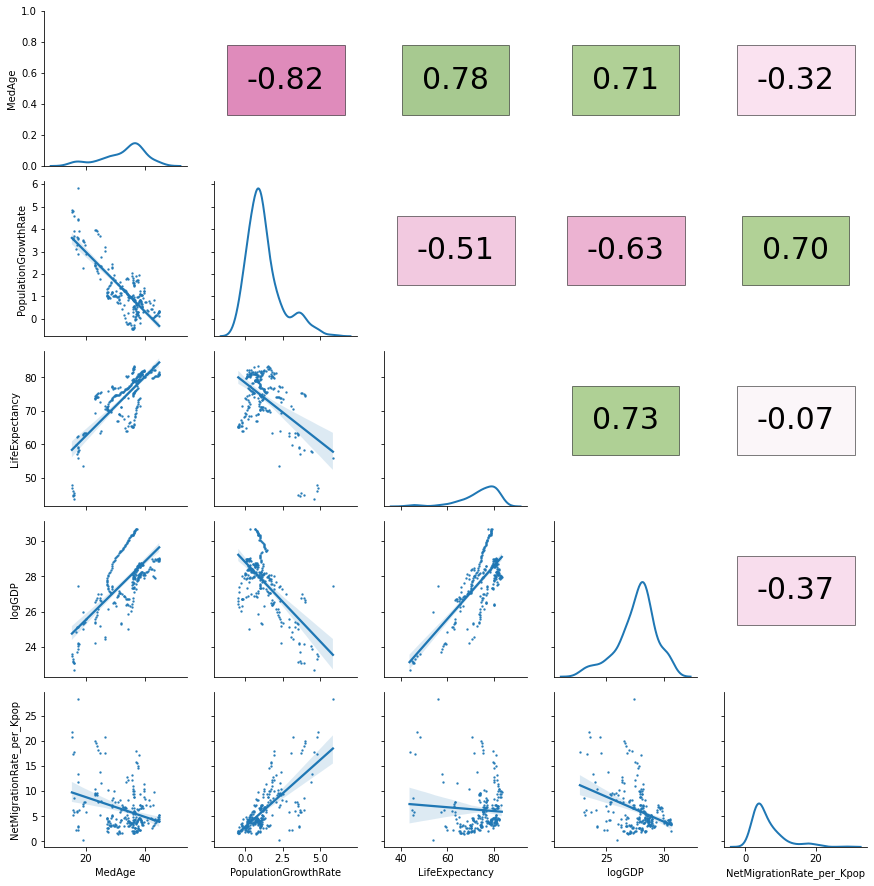

In [20]:
#
# PairGrid for countries receiving significant migration
#
# Filter on high positive migration, and remove columns that may not 
# pertain (Index, Year), stuck in the middle, and columns that will exhibit collinearity.
# Such removal of coolumns came after testing the PairGrid. It needed simplification.
#
positive_df = wpp_wb_df[(wpp_wb_df['NetMigrants_Ks'] > 200)].drop(['Index', 
                                                               'Year', 
                                                               'Population_Ks', 
                                                               'FertilityRate_births_per_woman',
                                                               'ImmigrantsEmigrants',
                                                               'ReceivesMigrants', 
                                                               'NetMigrants_Ks',
                                                               'GDP_USD', 
                                                               'GDP_growth_pct',
                                                               'GDP_PCAP_USD',
                                                               'Inflation_pct'
                                                               ], axis=1)

g = sns.PairGrid(positive_df, palette="Set2")

# Print corr coeffs on upper area (source https://stackoverflow.com/questions/67049647/customize-seaborn-pair-grid)
_=g.map_upper(reg_coef, cmap=plt.get_cmap('PiYG'))
_=g.map_lower(sns.regplot, order=1, truncate=True, scatter_kws={'s':2})
_=g.map_diag(sns.kdeplot, lw = 2)

plt.show()

# These countries (positive_df) are listed under Appendix A.

#### _Emigration: Negative Migration_


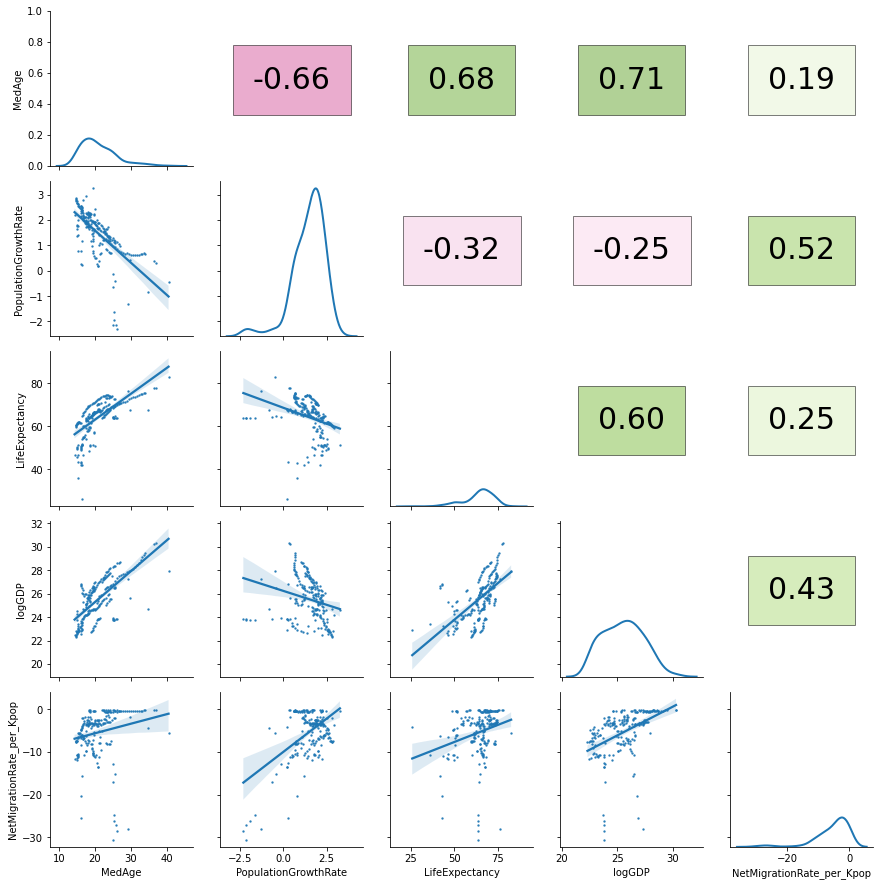

In [21]:
#
# PairGrid for countries receiving significant migration
#
# Filter on lower than -300K negative migration, and remove columns that may not 
# pertain (Index, Year), an columns that will exhibit collinearity.
# Such removal of coolumns came after testing the PairGrid. It needed simplification.
#

negative_df = wpp_wb_df[(wpp_wb_df['NetMigrants_Ks'] < -200)].drop(['Index', 
                                                               'Year', 
                                                               'Population_Ks', 
                                                               'FertilityRate_births_per_woman',
                                                               'ImmigrantsEmigrants', 
                                                               'ReceivesMigrants', 
                                                               'NetMigrants_Ks',
                                                               'GDP_USD', 
                                                               'GDP_growth_pct',
                                                               'GDP_PCAP_USD',
                                                               'Inflation_pct'
                                                               ], axis=1)

g = sns.PairGrid(negative_df, palette="Set2")

# Print corr coeffs on upper area (source https://stackoverflow.com/questions/67049647/customize-seaborn-pair-grid)
_=g.map_upper(reg_coef, cmap=plt.get_cmap('PiYG'))
_=g.map_lower(sns.regplot, order=1, truncate=True, scatter_kws={'s':2})
_=g.map_diag(sns.kdeplot, lw = 2)

plt.show()

# These countries (negative_df) are listed under Appendix A.

#### _Takeaways from PairGrid plots_

> - There is a very clear distinction between countries sending out migrants (emigration) versus countries receiving migrants (immigration) relative to **population growth and GDP**. Countries not growing will tend to receive migrants, while countries growing send out migrants.
> -  For the most part there is a clean separation between immigration and emigration. However, **there is an unbalance** caused by countries that experience **reverse patterns** in some years. That is, there are countries where in some years they sent migrants and other years they received migrants. That may be due to migration patterns specific to some countries. Those patterns cause some imbalances exhibited in the charts. It is not common for a country to reverse directions. We will visualize in a line plot in the next sections of this study. 
> - Notice the overall on the diagonal for **migration rate**. Together, immigration and emigration would form a nice Normal distribution. With the hue on **migration/immigration** we can see a distinction on emigration (negative rate) versus immigration (positive rate). And yet, notice the small overlap. That overlap is due to countries that experience a reverse pattern from time to time.
> - Two very interesting variables are **median age and population growth**. Those two variables should a clear distinction between countries sending versus receiving migrants.
> - **Median age** is lower for countries sending migrants than for countries receiving migrants. The Kdeplot on the diagonal of the PairGrid clearly exhibits a distribution indicating this observation. There is an overlap, still we can see how emigration countries have a lower median age than immigration countries; the younger populations tend to migrate to the older populations.
> - Population growth is higher for countries sending migrants than for countries receiving migrants. Here two, and even more significantly, the Kdeplot in the diagonal of the PairGrid clearly exhibits a distribution indicating this observation.
> - Between **median age** and **population growth**, one could create a logistic regression model to predict which countries are experiencing immigration versus migration.
> - Variables **median age, life expectancy** correlations (visually at this point) are reversed when comparing countries sending with countries receiving migrants.
> - Taking the **log of GDP** per capita greatly improved its bell shape, with characteristics of a Normal distribution for either immigration or migration. Emigration tends to have a lower GDP than immigration.
> - Notice **reversed slope** in the *Net Migration* versus *log GDP* plots comparing emigration with immigration plots.
> - There is a some correlation (visual separation) between **immigration** and **emigration** relative to **GDP** (log). One can observe **emigration** tends to have slightly lower **GDP**. That is an exogenous variable to test during **time series** analysis. The diagonal distribution plots have **emigration** left (lower mean GDP) of **immigration** (higher mean GDP).
> - **Correlation** between **median age and migration rate** is opposite for countries receiving migrants vs. countries sending migrants. 

Next in this study, I will further explore migration versus GDP, and will apply time series analysis to understand the behavior of migration country to country.

Inflation will be applied when exploring specific countries, in this case the United Stated and Mexico. Inflation in a worldwide basis did not exhibit significant effects on mogration. But inflation on a country-by-country basis did have a relationship with migration. That will be further explored under the United States and Mexico sections of this study.

### _Visualize Worldwide Migration: Line Plots Year/Year_

Begin by plotting all the data from 1960 to 2020 distinguishing countries that receive versus send migrants.

Passing all the countries in the dataset we will see the 95% confidence levels in the plots:

- Net migration rate
- GDP growth

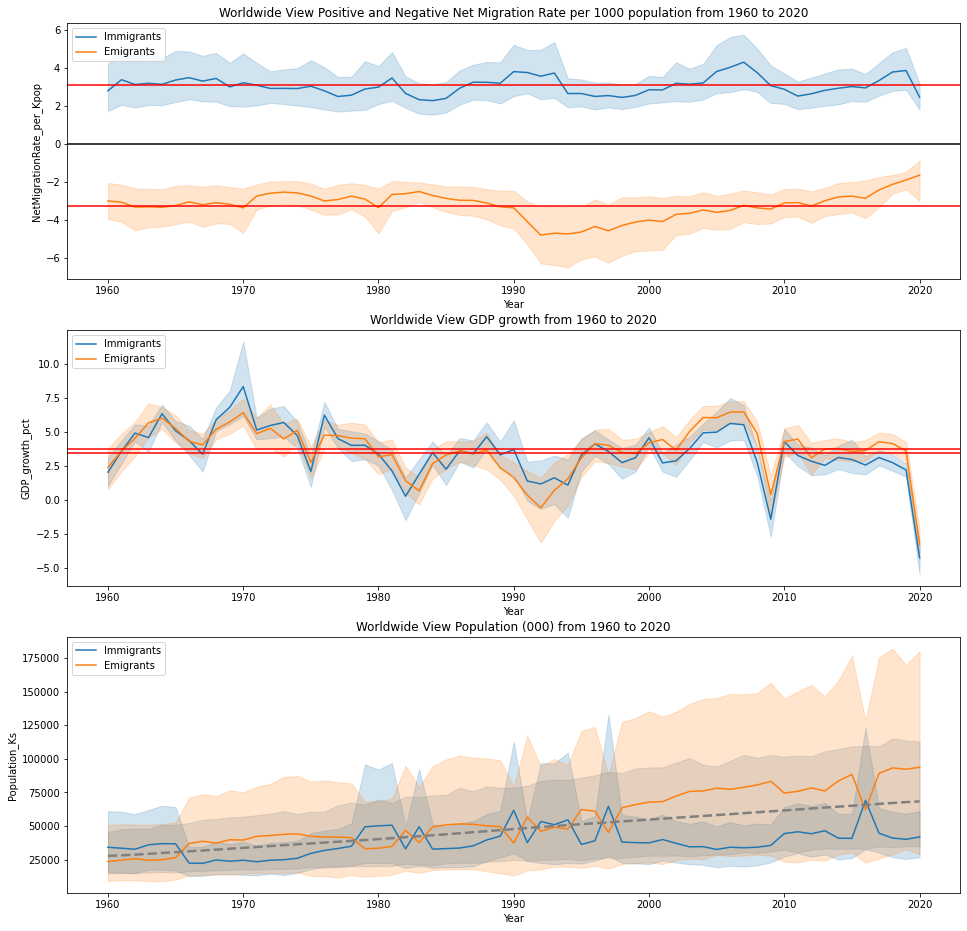

In [22]:
# Plot the time series
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
ax = ax.flatten()

ax[0] = sns.lineplot(x = 'Year', y = 'NetMigrationRate_per_Kpop', data = wpp_wb_df, hue='ImmigrantsEmigrants', ax=ax[0])
ax[0].set_title('Worldwide View Positive and Negative Net Migration Rate per 1000 population from 1960 to 2020')
ax[0].legend(loc='upper left')
ax[0].axhline(y = wpp_wb_df[(wpp_wb_df['ReceivesMigrants'] == 1)].NetMigrationRate_per_Kpop.mean(), 
              color = 'r', linestyle = '-')
ax[0].axhline(y = wpp_wb_df[(wpp_wb_df['ReceivesMigrants'] == 0)].NetMigrationRate_per_Kpop.mean(), 
              color = 'r', linestyle = '-')
ax[0].axhline(y = 0, color = 'black', linestyle = '-')

ax[1] = sns.lineplot(x = 'Year', y = 'GDP_growth_pct', data = wpp_wb_df, hue='ImmigrantsEmigrants', ax=ax[1])
ax[1].set_title('Worldwide View GDP growth from 1960 to 2020')
ax[1].legend(loc='upper left')
ax[1].axhline(y = wpp_wb_df[(wpp_wb_df['ReceivesMigrants'] == 1)].GDP_growth_pct.mean(), 
              color = 'r', linestyle = '-')
ax[1].axhline(y = wpp_wb_df[(wpp_wb_df['ReceivesMigrants'] == 0)].GDP_growth_pct.mean(), 
              color = 'r', linestyle = '-')

ax[2] = sns.lineplot(x = 'Year', y = 'Population_Ks', data = wpp_wb_df, hue='ImmigrantsEmigrants', ax=ax[2])
ax[2] = sns.lineplot(x = 'Year', y = 'Population_Ks', data = wpp_wb_df, color='grey', linewidth=2.5, linestyle = '--', ax=ax[2])
ax[2].set_title('Worldwide View Population (000) from 1960 to 2020')
ax[2].legend(loc='upper left')

plt.show()

### _Visualize Migration vs GDP: Scatter Plots Various Years_

The PairGrid plots demonstrated a relationship between GDP and migration. In this section we will further explore that relationship to see if there are changes, or consistencies, between migration and GDP over various years.


Scatterplots are for a worldwide country/country dataset: Each dot is a country.
Mexico (MEX) and the United States (USA) are highlighted in red, and ISO3 code.

Country/country Net Migration Rate (per 1000 pop.) vs. GDP per capity (log), from 1960 to 2020


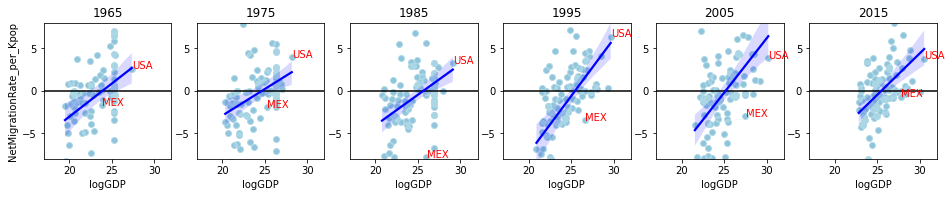

In [23]:
print('Scatterplots are for a worldwide country/country dataset: Each dot is a country.')
print('Mexico (MEX) and the United States (USA) are highlighted in red, and ISO3 code.')
print('\nCountry/country Net Migration Rate (per 1000 pop.) vs. GDP per capity (log), from 1960 to 2020')

plot_years = [1965, 1975, 1985, 1995, 2005, 2015]

##
#
# Plot six scattercharts with logGDP
#
##
fig,ax = plt.subplots(1, 6, figsize=(16, 2.5))
ax = ax.flatten()

for i, year in enumerate(plot_years):
    wpp_tmp = wpp_wb_df[wpp_wb_df['Year'] == year]
    
    # title = 'Migr Rate vs logGDP '+str(year)
    title = str(year)

    ax[i] = sns.scatterplot(data=wpp_tmp, x='logGDP', y='NetMigrationRate_per_Kpop', ax=ax[i])
    ax[i].set_title(title)
    ax[i].set_ylim(-8, 8)
    ax[i].set_xlim(17, 32)
    ax[i].axhline(y = 0, color = 'black', linestyle = '-')

    sns.regplot(x='logGDP', y='NetMigrationRate_per_Kpop', data=wpp_tmp,
                scatter_kws={"color": "lightblue"}, line_kws={"color": "blue"}, ax=ax[i])

    label_point(x=wpp_tmp[wpp_tmp['ISO2'] == 'MX'].logGDP,
                y=wpp_tmp[wpp_tmp['ISO2'] == 'MX'].NetMigrationRate_per_Kpop, 
                s=wpp_tmp[wpp_tmp['ISO2'] == 'MX'].ISO3, 
                color='red', ax=ax[i])  

    label_point(x=wpp_tmp[wpp_tmp['ISO2'] == 'US'].logGDP,
                y=wpp_tmp[wpp_tmp['ISO2'] == 'US'].NetMigrationRate_per_Kpop, 
                s=wpp_tmp[wpp_tmp['ISO2'] == 'US'].ISO3, 
                color='red', ax=ax[i])  

    if i != 0:
        ax[i].set_ylabel(None)

#### _Takeaways from lineplots and migration vs GDP (log) scattercharts_

The plots distinguish countries sending migrants (emigrants) versus receiving migrants (immigrants). The key variable is Net Migration Rate per 1000 people. The dataset is cleaned from extreme outliers.

> - Line plots displaying sending vs receiving migrants tend to **mirror each other**. There are **imbalances** due to reverse patterns in migration. 
>
> - Population relative to migrating versus immigrating shifts from time to time. That could be a stochastic behavior, or a trend driven by change in regime or state.
>
> - Countries receiving migrants and countries sending migrants mirror each other's migration trends in terms if Net Migration Rate. That is intuitive, but it needed to be tested to check impact on country sizes that would throw the balance of this mirror off. 
>
> - GDP trends in relative unison worldwide. *Net Migration Rate* has a positive relationship with *log GDP.* The plots Net Migration vs log GDP show a relatively consistent positive trend as one may have expected: The regression lines are all positive. The poorer countries--in terms of GDP--lose migrants while the wealthier countries receive migrants.
>
> - We begin to see GDP acting as an exogenous variable on migration trends. Notice that in general, a low GDP influences migration.
>
> - There is a significant outlier in trend **in 2021 and 2020 due to Covid-19**. There, GDP plunges and so does migration. Many countries basically closed their borders, including the United States.
>
> - Migration basically **stopped during the Covid-19 crisis** worldwide. Further exploration would show that those large negative numbers rate number in 2020 came from countries like Qatar, exhibiting an opposite trend during Covid-19.
>
> - Covid-19 caused an unprecedented migration behavior in recent history, at least within the year 1960 to 2020. Therefore, if looking for correlations, using years 2019 to 2020 may be biased. It should not be ignored, and in fact such event supports the notion of how migration is influenced by external events, such as the economy, environment, wars, etc. But to study the relationship between economic conditions and migration, it would be wise to remove those years 2019 to 2020.
>
> - Another observation is the variation from country to country. Take again 1985 where the countries are spread very widely relative to Net Migration. On the other hand, a year like 1995, tens year later, the spread is more compact. The confidence levels are a good indicator on this observation.
>


### _Normalize the DataFrame_

Normilize the DataFrame and verify results. Normalization will enable further exploration using **time series** tools.

In [24]:
# Normalize seelcted set of numeric columns
n_wpp_wb_df = normalize_df(wpp_wb_df, cols=['Population_Ks',
                                            'MedAge', 
                                            'PopulationGrowthRate', 
                                            'FertilityRate_births_per_woman',
                                            'LifeExpectancy', 
                                            'GDP_USD',
                                            'logGDP', 
                                            'GDP_growth_pct',
                                            'GDP_PCAP_USD', 
                                            'Inflation_pct',
                                            'NetMigrants_Ks', 
                                            'NetMigrationRate_per_Kpop'])
# n_wpp_wb_df.describe()

In [25]:
# n_wpp_wb_df.info()

In [26]:
# n_wpp_wb_df.head()

### _Visualize and Verify Normalized DataFrame_

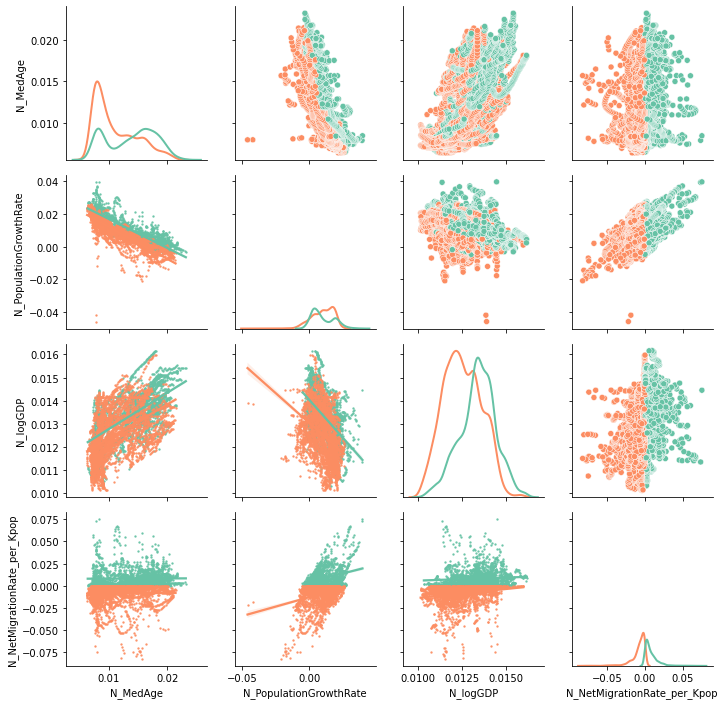

In [27]:
#
# PairGrid for countries receiving significant migration
#
g = sns.PairGrid(n_wpp_wb_df.drop(['Index', 'Year', 'N_Population_Ks', 'N_FertilityRate_births_per_woman',
                              'N_LifeExpectancy', 'ReceivesMigrants', 'N_NetMigrants_Ks', 
                              'N_GDP_USD', 'N_GDP_growth_pct', 'N_GDP_PCAP_USD', 'N_Inflation_pct'], axis=1),
                 hue='ImmigrantsEmigrants', palette="Set2")

# _=g.map_upper(reg_coef, cmap=plt.get_cmap('PiYG'))
_=g.map_upper(sns.scatterplot)
_=g.map_lower(sns.regplot, order=1, truncate=True, scatter_kws={'s':2})
_=g.map_diag(sns.kdeplot, lw = 2)

plt.show()

#### _Takeaways from Normalized PairGrid plots_

> - There is consistency between the original and the normalized datasets. Moving forward, the study will be based on the normalized dataset. The plot uses *hue=Immigrants/Emigrants* to give us another visual, more information.
>
> - Notice the *log GDP* distribution plots. Countries receiving migrants (*immigrants*) have a higher mean than countries sending migrants (*emigrants*).
>
> - We see a similar different in the distributions for *Median Age*.
>
> - *Population growth* is another interesting variable. The only caution is, this data point depends on the country size (it is growth). 
>
> - *Inflation* (not included in these plots) will be relevant when comparing specific countries. In a worldwide basis, *inflation* did not  provide too much information (while experimenting with these charts). It will be used in the plots for United States and Mexico later in this study. 

## Time Series Preparation - Worldwide Migration  

For now, let's keep a world view. I will be focusing on the United States and Mexico. I want to study migration data worldwide  to build an educated perspective before exploring the United States and Mexico.

### _Create Normalized Time Series DataFrame_

Create a Time Series DataFrame for our variables of interest. All columns will be numeric, and they will be normalized. 

#### _Apply OLS model coefficients to build a DataFrame_

The following script uses OLS to extract the means year/year of Immigration, Emigration, and GDP growth rate for countries taking immigrants from other countries and countries sending emigrants out to other countries. It is another way to clean up the plots from the previous section and obtain a time series for each case.

- Make Year the Index of the DataFrame.
- Create Migration Rates columns for immigration and emigration.
- Create Net Migration columns for immigration and emigration.
- Create GDP Rates columns for immigration and emigration.

OLS models give us coefficients with the mean values of the variables under the test, as shown in the following scripts.

In [28]:
##
#
# Now plot the change in slopes underneath the scatterplots
#
# Get the parameters from OLS model.
# Intercepts = Send migrants (negative migration)
# Slope (parameter) = ReceivesMigrants (positive migration)
#
##

# Get two OLS parameters for each year iteration.
# Two parameters, B0 and B1 for a linear formula y = B0 + B1 x
migr_rate_b0 = []
migr_rate_b1 = []
net_migr_b0 = []
net_migr_b1 = []
gdp_b0 = []
gdp_b1 = []
log_gdp_b0 = []
log_gdp_b1 = []
pop_b0 = []
pop_b1 = []
year_model = []

pop_tot_mr = []
pop_tot_nm = []
mean_pop_tot = []
mean_logGDP = []
mean_GDP_growth_pct = []

# Test patterns including 1960s and one year before Covid-19.
for year in range(1960,2021):
    
    wpp_tmp = n_wpp_wb_df[n_wpp_wb_df['Year'] == year]
    
    # Receive migrants is a cathegorical variable. In the formula subtract 1 to avoid the intercept.
    ols_mig_rate_model = smf.ols(formula = 'N_NetMigrationRate_per_Kpop ~ C(ImmigrantsEmigrants) - 1', data=wpp_tmp).fit()
    ols_net_mig_model = smf.ols(formula = 'N_NetMigrants_Ks ~ C(ImmigrantsEmigrants) - 1', data=wpp_tmp).fit()
    ols_gdp_grth_model = smf.ols(formula = 'N_GDP_growth_pct ~ C(ImmigrantsEmigrants) - 1', data=wpp_tmp).fit()
    ols_log_gdp_model = smf.ols(formula = 'N_logGDP ~ C(ImmigrantsEmigrants) - 1', data=wpp_tmp).fit()
    ols_pop_model = smf.ols(formula = 'N_Population_Ks ~ C(ImmigrantsEmigrants) - 1', data=wpp_tmp).fit()
    
    migr_rate_b0.append(ols_mig_rate_model._results.params[0])
    migr_rate_b1.append(ols_mig_rate_model._results.params[1])

    net_migr_b0.append(ols_net_mig_model._results.params[0])
    net_migr_b1.append(ols_net_mig_model._results.params[1])

    gdp_b0.append(ols_gdp_grth_model._results.params[0])
    gdp_b1.append(ols_gdp_grth_model._results.params[1])

    log_gdp_b0.append(ols_log_gdp_model._results.params[0])
    log_gdp_b1.append(ols_log_gdp_model._results.params[1])

    pop_b0.append(ols_pop_model._results.params[0])
    pop_b1.append(ols_pop_model._results.params[1])
    
    mean_pop_tot.append(wpp_tmp[wpp_tmp['Year'] == year].N_Population_Ks.mean())
    mean_logGDP.append(wpp_tmp[wpp_tmp['Year'] == year].N_logGDP.mean())
    mean_GDP_growth_pct.append(wpp_tmp[wpp_tmp['Year'] == year].N_GDP_growth_pct.mean())

    year_model.append('31DEC'+str(year))

# Build the DataFrame using dictionary
n_migr_gdp_df = pd.DataFrame({'Year':year_model, 
                            'N_EmigrationRate':migr_rate_b0, 'N_ImmigrationRate':migr_rate_b1,
                            'N_NetEmigration':net_migr_b0, 'N_NetImmigration':net_migr_b1,
                            'N_EmigrationGDPgrowth':gdp_b0, 'N_ImmigrationGDPgrowth':gdp_b1,
                            'N_EmigrationLogGDP':log_gdp_b0, 'N_ImmigrationLogGDP':log_gdp_b1,
                            'N_EmigrationPop':pop_b0, 'N_ImmigrationPop':pop_b1,
                            'N_PopulationTot':mean_pop_tot, 'N_logGDP':mean_logGDP, 'N_GDP_growth_pct':mean_GDP_growth_pct})

#### _Set index to 'Year' for the time series_

In [29]:
n_migr_gdp_df.Year = pd.to_datetime(n_migr_gdp_df['Year'], format='%d%b%Y')
n_migr_gdp_df.set_index('Year', inplace=True)

# n_migr_gdp_df.info()

#### _Size of train data set_

This study includes time series predictions of forecasts. The purpose for setting the train set size here is to have some consistency during the application of the prediction methods. We still have the flexibility to hard coded down stream if necessary.

In [30]:
# Given the size of the dataset and the pupose for forecasting:
train_size = 50

#### _Verify New DataFrame PairGrid / Correlations: Emigration vs Immigration Granularity_

We have a transformed dataset that needs to be checked again.

#### _Plot the Time Series: Immigration, Emigration, and GDP_

Normalized World Wide Time Series




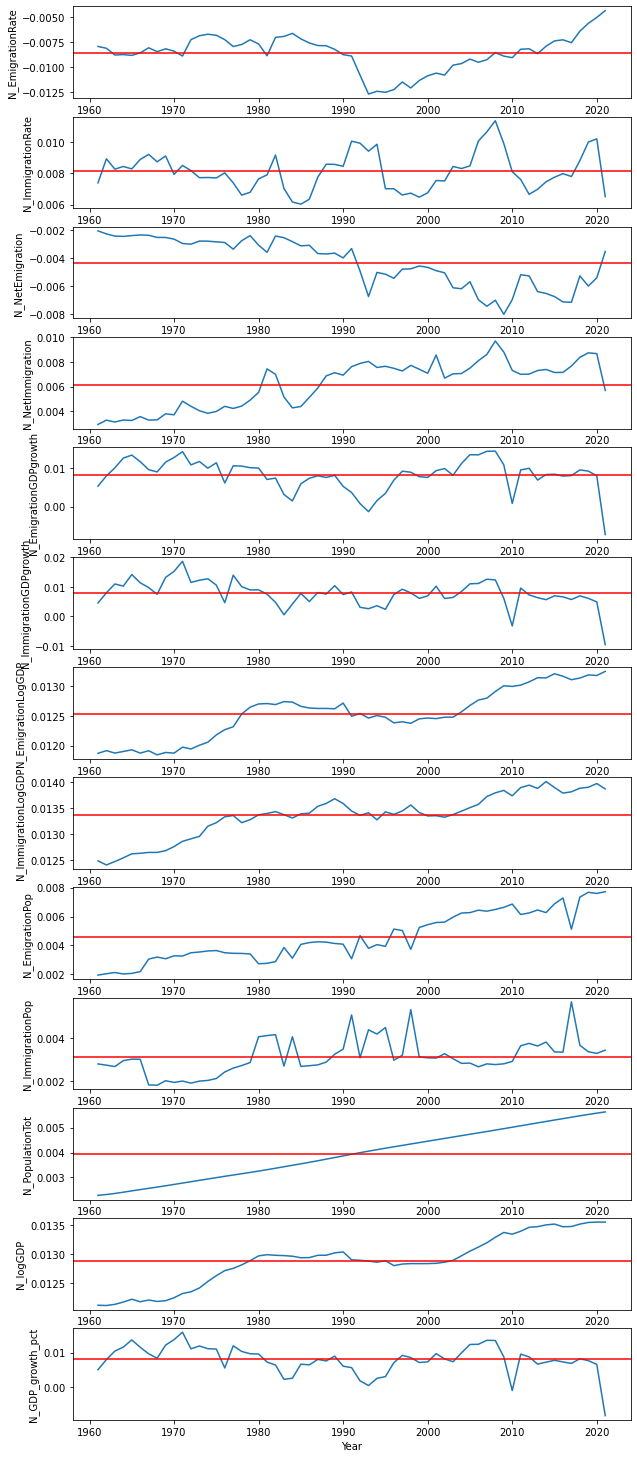

In [31]:
print('Normalized World Wide Time Series\n\n')
lineplots_ts(n_migr_gdp_df)

#### _Takeaways from worldwide time series (Normalized means)_

As with the previous approach, these plots distinguish countries with positive migration versus countries with negative migration.

We concur with the conclusions drawn from the previous sections in a different way:

> - Countries receiving migrants and countries sending migrants **mirror each other's migration trends**. 
>
> - Net migration (immigration and migration) has trends following population grows. Notice how the mean splits those lines depending on the trendline. 
>
> - There is a **significant outlier in trends** during the **Covid-19 years (2020)**. Covid-19 caused unprecedented migration behaviors.
>
> - The Immigration and emigration population reflect the population of the countries with positive versus negative migration on a year-by-year basis. 
>
> - The time series observe **stochastic trend.** There are many factors contributing to those stochastic movements. There are a few cases where a country experiences a revere migration (e.g., when normally a country has emigration, there are times when the country experience actually immigration, not often). Normally a country consistently experiences either emigration or immigration consistently, but it is not always consistent.
>
> - Therefore, this data is stochastic and **out of balance.** We can explore analysis and identify insights: We can tell GDP is a force that impact migration; we can tell that those countries with a faster population growth tend to experience emigration vs countries with slow population growth that tend to experience more immigration (more people coming in there).

Next in this study, I will further explore migration versus GDP, and will apply time series analysis to understand the behavior of migration country to country.

## Write to CSV

In [32]:
# Write n_migr_gdp_df to csv
n_migr_gdp_df.to_csv('data/normalized_world_migration_and_gdp.csv')

# References 
1. United Nations Datamart (accessed Sep. 13, 2022) http://data.un.org/
1. United Nations Datamart (accessed Sep. 13, 2022) http://data.un.org/Explorer.aspx
1. United Nations Datamart - World Population Prospects (accessed Sep. 13, 2022) https://population.un.org/wpp/Download/Standard/MostUsed/
1. World Bank DataBank. Global Bilateral Migration (accessed Nov. 7, 2022) https://databank.worldbank.org/source/global-bilateral-migration/Type/TABLE/preview/on#
1. World Bank Leading https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?view=charthttps://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?view=chart
1. World Bank World Development Indicators (accessed Nov. 21, 2022) P_Data_Extract_From_World_Development_Indicators https://databank.worldbank.org/source/world-development-indicators
1. World Bank World GDP (accessed Nov. 23, 2022) https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG file API_NY.GDP.MKTP.KD.ZG_DS2_en_excel_v2_4701280.xls
1. Jake VanderPlasJake VanderPlas. "Python Data Science HandbookPython Data Science Handbook" Released November 2016. Publisher(s): O'Reilly Media, Inc. ISBN: 9781491912058b. (chapters included https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
1. Stackoverflow community. (accessed Dec. 14, 2022) https://stackoverflow.com/
1. Geeks for Geeks. Python community. (accessed Dec. 12, 2022) https://www.geeksforgeeks.org/python-programming-language/
1. Pandas documentation. (accessed Sep. 20, 2022) https://pandas.pydata.org/docs/user_guide/index.html
1. "Pandas General Functions" (accessed Sep. 4, 2022) https://pandas.pydata.org/pandas-docs/stable/reference/general_functions.html
1. Seaborn documentation (accessed Sep. 12, 2022) https://seaborn.pydata.org/
1. matplotlib documentation (accessed Sep. 12, 2022) https://matplotlib.org/
1. NumPy documentation (accessed Sep. 12, 2022) https://numpy.org/
1. matplotlib documentation (accessed Sep. 12, 2022) https://matplotlib.org/
1. satsmodels documentation (accessed Dec. 14, 2022) https://statsmodels.org/
1. SciPy stats (accessed Sep. 20, 2022) https://docs.scipy.org/doc/scipy/reference/stats.html
